# Exploratory Data Analysis (EDA) 
Purpose: For Cervical Spine Fracture Dataset

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
from pathlib import Path

root_path = Path('/content/drive/MyDrive/cervical fracture')
train_fracture = root_path / 'train/fracture'
train_normal   = root_path / 'train/normal'
val_fracture   = root_path / 'val/fracture'
val_normal     = root_path / 'val/normal'

In [3]:
!ls "/content/drive/MyDrive/cervical fracture/train/fracture" | head

CSFDV1B10 (18)-rotated3-rotated2.png
CSFDV1B10 (18)-rotated3-rotated3.png
CSFDV1B10 (18)-sharpened1.png
CSFDV1B10 (18)-sharpened1-rotated1.png
CSFDV1B10 (18)-sharpened1-rotated2.png
CSFDV1B10 (18)-sharpened1-rotated3.png
CSFDV1B10 (18)-sharpened.png
CSFDV1B10 (18)-sharpened-rotated1.png
CSFDV1B10 (18)-sharpened-rotated2.png
CSFDV1B10 (18)-sharpened-rotated3.png


In [4]:
!pip install pydicom

In [5]:
!pip install pylibjpeg pylibjpeg-libjpeg pydicom[gdcm]

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 71.8 MB/s eta 0:00:00


In [6]:
from pathlib import Path
import pydicom
import cv2
import numpy as np
import pandas as pd

In [7]:
import pydicom
print("pydicom version:", pydicom.__version__)

pydicom version: 3.0.1


In [9]:
try:
    print(eda_df.shape)
except NameError:
    print("eda_df not found — please re-run the cell that creates it.")

eda_df not found — please re-run the cell that creates it.


In [12]:
def inspect_folder(folder, sample_cap=3000):
    rows = []
    paths = list(Path(folder).rglob('*'))
    paths = paths[:sample_cap] if len(paths) > sample_cap else paths
    for p in paths:
        if p.is_dir():
            continue
        ext = p.suffix.lower()
        try:
            if ext in ['.dcm', '.dicom']:
                ds = pydicom.dcmread(str(p), stop_before_pixels=False)
                arr = ds.pixel_array
                h, w = arr.shape[-2], arr.shape[-1]
                rows.append({
                    'path': str(p),
                    'ext': ext,
                    'width': w,
                    'height': h,
                    'mean': float(arr.mean()),
                    'std': float(arr.std()),
                    'pt_id': str(ds.get('PatientID', 'NA')),
                    'study_uid': str(ds.get('StudyInstanceUID', 'NA')),
                    'series_uid': str(ds.get('SeriesInstanceUID', 'NA')),
                })
            else:
                img = cv2.imread(str(p), cv2.IMREAD_GRAYSCALE)
                if img is None:
                    continue
                h, w = img.shape
                rows.append({
                    'path': str(p),
                    'ext': ext,
                    'width': w,
                    'height': h,
                    'mean': float(img.mean()),
                    'std': float(img.std()),
                    'pt_id': 'NA',
                    'study_uid': 'NA',
                    'series_uid': 'NA',
                })
        except Exception as e:
            continue
    return pd.DataFrame(rows)

# Now run this block to create all four DataFrames
train_fx_df = inspect_folder(train_fracture)
train_nm_df = inspect_folder(train_normal)
val_fx_df   = inspect_folder(val_fracture)
val_nm_df   = inspect_folder(val_normal)

In [13]:
print(len(train_fx_df), len(train_nm_df), len(val_fx_df), len(val_nm_df))

1900 1900 200 200


In [14]:
eda_df = pd.concat([
    train_fx_df.assign(split='train', label='fracture'),
    train_nm_df.assign(split='train', label='normal'),
    val_fx_df.assign(split='val', label='fracture'),
    val_nm_df.assign(split='val', label='normal')
], ignore_index=True)

eda_df.head()

,path,ext,width,height,mean,std,pt_id,study_uid,series_uid,split,label
0,/content/drive/MyDrive/cervical fracture/train...,.png,224,224,133.757474,84.224374,NA,NA,NA,train,fracture
1,/content/drive/MyDrive/cervical fracture/train...,.png,224,224,133.101941,84.456744,NA,NA,NA,train,fracture
2,/content/drive/MyDrive/cervical fracture/train...,.png,224,224,143.425981,90.850131,NA,NA,NA,train,fracture
3,/content/drive/MyDrive/cervical fracture/train...,.png,224,224,153.438337,95.381875,NA,NA,NA,train,fracture
4,/content/drive/MyDrive/cervical fracture/train...,.png,224,224,133.598015,84.322311,NA,NA,NA,train,fracture


,split,label,count
0,train,fracture,1900
1,train,normal,1900
2,val,fracture,200
3,val,normal,200


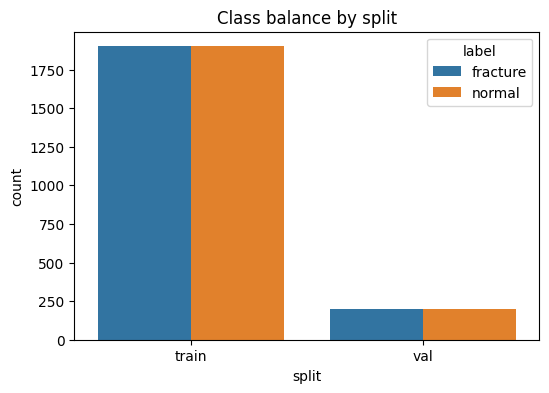

In [15]:
import seaborn as sns, matplotlib.pyplot as plt

# Counts by split and label
cnt = eda_df.groupby(['split','label']).size().reset_index(name='count')
display(cnt)

plt.figure(figsize=(6,4))
sns.barplot(data=cnt, x='split', y='count', hue='label')
plt.title('Class balance by split')
plt.show()

In [16]:
def leakage_report(df, id_col):
    if id_col not in df.columns:
        print(f"Column '{id_col}' not found. Skipping.")
        return
    a = set(df[df['split']=='train'][id_col]) - {'NA','ERR',None,np.nan}
    b = set(df[df['split']=='val'][id_col])   - {'NA','ERR',None,np.nan}
    inter = a & b
    print(f"Leakage by {id_col}: {len(inter)} overlapping IDs")
    if len(inter) > 0:
        display(df[df[id_col].isin(list(inter))][['path','split','label',id_col]].head())

leakage_report(eda_df, 'pt_id')
leakage_report(eda_df, 'study_uid')

Leakage by pt_id: 0 overlapping IDs
Leakage by study_uid: 0 overlapping IDs


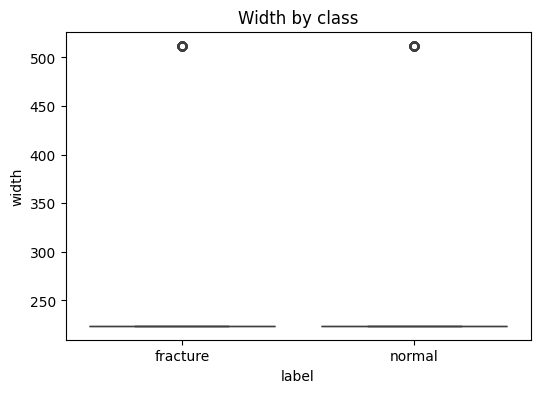

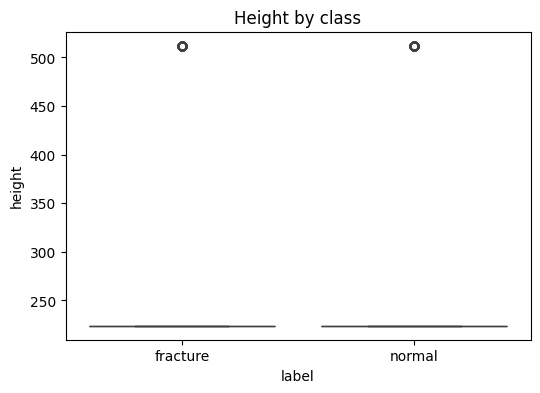

Recommended training resize: 224 x 224 (or 224 x 224 if using ImageNet backbones)


In [17]:
plt.figure(figsize=(6,4))
sns.boxplot(data=eda_df, x='label', y='width')
plt.title('Width by class'); plt.show()

plt.figure(figsize=(6,4))
sns.boxplot(data=eda_df, x='label', y='height')
plt.title('Height by class'); plt.show()

# Suggested canonical size
common_w = eda_df['width'].mode().iloc[0] if eda_df['width'].notna().any() else 224
common_h = eda_df['height'].mode().iloc[0] if eda_df['height'].notna().any() else 224
print(f"Recommended training resize: {common_h} x {common_w} (or 224 x 224 if using ImageNet backbones)")

In [18]:
# z-scores for brightness and contrast
eda_df['z_mean'] = (eda_df['mean'] - eda_df['mean'].mean()) / (eda_df['mean'].std()+1e-6)
eda_df['z_std']  = (eda_df['std']  - eda_df['std'].mean())  / (eda_df['std'].std()+1e-6)

bad = eda_df[(eda_df['z_mean'].abs()>3) | (eda_df['z_std'].abs()>3)]
print(f"Flagged quality outliers: {len(bad)} files")
display(bad[['path','split','label','mean','std']].head())

Flagged quality outliers: 3 files


,path,split,label,mean,std
3404,/content/drive/MyDrive/cervical fracture/train...,train,normal,151.195771,112.925360
3409,/content/drive/MyDrive/cervical fracture/train...,train,normal,150.390187,113.277818
3668,/content/drive/MyDrive/cervical fracture/train...,train,normal,151.906071,112.871526


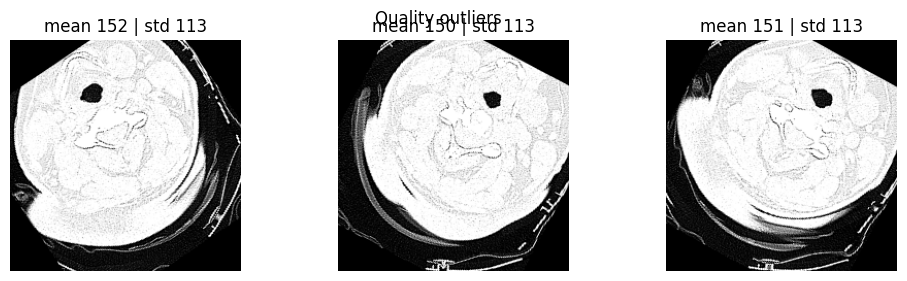

In [19]:
import cv2, matplotlib.pyplot as plt
n = min(4, len(bad))
plt.figure(figsize=(12,3))
for i, row in enumerate(bad.sample(n, random_state=0).itertuples()):
    img = cv2.imread(row.path, cv2.IMREAD_GRAYSCALE)
    plt.subplot(1,n,i+1); plt.imshow(img, cmap='gray'); plt.axis('off')
    plt.title(f"mean {row.mean:.0f} | std {row.std:.0f}")
plt.suptitle('Quality outliers'); plt.show()

In [21]:
# Exact path duplicates
dup_paths = eda_df[eda_df.duplicated('path', keep=False)]
print(f"Exact path duplicates: {dup_paths.shape[0]}")
if len(dup_paths): display(dup_paths.head())

# Optional: hash-based near-duplicate check for PNG/JPG
import hashlib, os
def file_md5(p, first_n_bytes=None):
    h = hashlib.md5()
    with open(p,'rb') as f:
        if first_n_bytes:
            h.update(f.read(first_n_bytes))
        else:
            for chunk in iter(lambda: f.read(8192), b''): h.update(chunk)
    return h.hexdigest()

sample_paths = eda_df[eda_df['ext'].isin(['.png','.jpg','.jpeg'])]['path'].sample(min(1000, len(eda_df))).tolist()
hashes = {}
dups = []
for p in sample_paths:
    try:
        h = file_md5(p, first_n_bytes=200000)  # fast partial hash
        if h in hashes: dups.append((p, hashes[h]))
        else: hashes[h] = p
    except Exception: pass
print(f"Near-duplicate images in sample: {len(dups)}")

Exact path duplicates: 0
Near-duplicate images in sample: 10


In [22]:
save_dir = Path('/content/drive/MyDrive/cervical fracture/eda_exports')
save_dir.mkdir(parents=True, exist_ok=True)

eda_df.to_csv(save_dir/'eda_summary.csv', index=False)
cnt.to_csv(save_dir/'class_counts.csv', index=False)
print("Saved:", save_dir)

Saved: /content/drive/MyDrive/cervical fracture/eda_exports


Confirmation that we are working with clear data.
Mounted Google Drive; Defined File Paths; Inspected Image Folders; Combined All Sets; Checked Dataset Balace; Verified Data Integrity; Evaluated Image Quality; Saved Results